In [30]:
import pandas as pd
pd.options.mode.chained_assignment = None

df_gdp = pd.read_excel('data/mpd2023_provisional.xlsx', sheet_name='GDPpc')
df_regions = df_gdp[:2]
df_regions = df_regions.T
df_regions = df_regions[1:]
df_regions = df_regions.reset_index()

df_regions.columns = ['country_name', 'region', 'iso_a3']

df_gfp_values = df_gdp[2:]
df_gfp_values = df_gfp_values[~df_gfp_values['GDP pc 2011 prices'].isna()]
df_gfp_values = df_gfp_values.set_index('GDP pc 2011 prices')
df_gfp_values = df_gfp_values.unstack().reset_index()
df_gfp_values.columns = ['country_name', 'year', 'gdp_pc']
df_gfp_values = df_gfp_values.dropna()
df_gfp_values = df_gfp_values[df_gfp_values['year']<=1900]

df_gfp_values = pd.merge(df_gfp_values, df_regions, on = 'country_name')
df_gfp_values = df_gfp_values.reset_index(drop=True)
df_gfp_values = df_gfp_values.drop(columns=['region'])

len(set(df_gfp_values['country_name']))

77

In [31]:
list(df_gfp_values[df_gfp_values['year']<=10]['country_name'])

['Belgium',
 'Switzerland',
 'Egypt',
 'Spain',
 'France',
 'Greece',
 'Iran (Islamic Republic of)',
 'Iraq',
 'Israel',
 'Italy',
 'Jordan',
 'Portugal',
 'Tunisia',
 'Turkey']

In [32]:
df_gfp_values[['country_name', 'iso_a3']].drop_duplicates().reset_index(drop=True).to_csv('data/iso.csv')

### Load Population

In [33]:
df_population = pd.read_excel('data/mpd2023_provisional.xlsx', sheet_name='Population')
df_population = df_population[2:]
df_population = df_population[~df_population['Population'].isna()]
df_population = df_population.set_index('Population')
df_population = df_population.unstack().reset_index()
df_population.columns = ['country_name', 'year', 'pop']
df_population = df_population[df_population['year']<=1900]

len(set(df_population['country_name']))

169

### Interpolate Population

In [34]:
import itertools

all_years = range(1, 1901)
all_countries = df_population['country_name'].unique()
df_regions_years = pd.DataFrame(list(itertools.product(all_countries, all_years)), columns=['country_name', 'year'])

df_population_all = pd.merge(df_population, df_regions_years, on = ['country_name', 'year'], how = 'outer')
df_population_all = df_population_all.sort_values(by=['country_name', 'year'])

# Bfore 1800, interloate linearly, after 1800, interpolate exponentially
#linear_interpolated = df_population_all[df_population_all['year'] <= 1800]
linear_interpolated = df_population_all.copy()

### Linear Interpolation Before 1800

In [35]:
df_int = []
for country in linear_interpolated['country_name'].unique():
    res= linear_interpolated[linear_interpolated['country_name']==country]
    res['pop'] = pd.to_numeric(res['pop'], errors='coerce')
    res['pop'] = res['pop'].interpolate(how = 'linear')
    df_int.append(res)

linear_interpolated_final = pd.concat([x for x in df_int])
linear_interpolated_final = linear_interpolated_final.dropna().reset_index(drop=True)

In [36]:
test = linear_interpolated_final.copy()
test = test[test['country_name']=='China']
test[test['year']==1100]

,country_name,year,pop
15705,China,1100,67800.0


### Concat the two datasets

In [37]:
df_population_interpolated = linear_interpolated_final.copy()
# df_population_interpolated = pd.concat([linear_interpolated_final, expo_interpolated_final])
df_population_interpolated = df_population_interpolated.dropna()
df_population_interpolated.to_csv('data/population_interpolated.csv')

### Merge population and GDP per capita

In [38]:
df_gdp_population = pd.merge(df_population_interpolated, df_gfp_values, on = ['country_name', 'year'], how = 'right')

### Regions Analysis

In [39]:
# load regions and equivalent country_name
df_regions_culture = pd.read_csv('data/ENS - Cultural Index - Countries Databases - consolidate_table.csv')
df_regions_culture = df_regions_culture[['region', 'iso_a3']].drop_duplicates()
list(set(df_regions_culture.region))
df_regions_culture[df_regions_culture['region']=='Chinese world']

,region,iso_a3
44,Chinese world,MNG
45,Chinese world,TWN
46,Chinese world,CHN


In [40]:
keep_regions_list = ['Italy',
 'Portugal', #OK
 'Low countries', # Weighted Average of Belgium and Netherlands normalized by population
 'Nordic countries', 
 'Indian world',
 'Chinese world',
 'Korea',
 'Arabic world',
 'Greek World',
 'Eastern Europe',
 'France',
 'Persian world',
 'Japan',
 'Latin World',
 'Spain',
 'United Kingdom',
 'Balkans',
 'German world']

In [41]:
df_gdp_pop_regions = pd.merge(df_gdp_population, df_regions_culture, on = ['iso_a3'])
df_gdp_pop_regions = df_gdp_pop_regions[df_gdp_pop_regions['region'].isin(keep_regions_list)]

In [42]:
df_gdp_weighted = df_gdp_pop_regions.groupby(['region', 'year']).apply(lambda x: (x['gdp_pc'] * x['pop']).sum() / x['pop'].sum())
df_gdp_weighted = df_gdp_weighted.reset_index()
df_gdp_weighted = df_gdp_weighted.rename(columns={0: 'gdp_pc_weighted'})

# df_gdp_weighted = df_gdp_weighted[df_gdp_weighted['year']>1]

# # Step 1: Round the 'year' column to the nearest multiple of 50
# df_gdp_weighted = df_gdp_weighted[df_gdp_weighted['year']>=1000]
# df_gdp_weighted = df_gdp_weighted[df_gdp_weighted['year']<=1880]

#df_gdp_weighted['decade'] = (df_gdp_weighted['year'] // 50) * 50

df_gdp_weighted['decade'] = df_gdp_weighted['year'].apply(lambda x: round(x / 50) * 50)
df_gdp_weighted = df_gdp_weighted.groupby(['region', 'decade'])['gdp_pc_weighted'].mean().reset_index()

df_gdp_pop_regions['decade'] = df_gdp_pop_regions['year'].apply(lambda x: round(x / 50) * 50)
df_gdp_pop_regions = df_gdp_pop_regions.groupby(['region', 'decade'])['pop'].mean().reset_index()

# Add population

df_pop_regions = df_gdp_pop_regions.groupby(['region', 'decade']).apply(lambda x: x['pop'].sum()).reset_index()
df_pop_regions = df_pop_regions.rename(columns={0: 'pop'})


# Weighted GDP and population
df_gdp_weighted_pop = pd.merge(df_gdp_weighted, df_pop_regions, on = ['region', 'decade'])
df_gdp_weighted_pop.to_csv('data/gdp_weighted_pop_fifty.csv', index=False)

### Every 10 years

In [43]:
df_gdp_pop_regions = pd.merge(df_gdp_population, df_regions_culture, on = ['iso_a3'])
df_gdp_pop_regions = df_gdp_pop_regions[df_gdp_pop_regions['region'].isin(keep_regions_list)]

df_gdp_weighted = df_gdp_pop_regions.groupby(['region', 'year']).apply(lambda x: (x['gdp_pc'] * x['pop']).sum() / x['pop'].sum())
df_gdp_weighted = df_gdp_weighted.reset_index()
df_gdp_weighted = df_gdp_weighted.rename(columns={0: 'gdp_pc_weighted'})

df_gdp_weighted[df_gdp_weighted['year']<1000]

,region,year,gdp_pc_weighted
0,Arabic world,1,1116.000000
1,Arabic world,730,1243.213115
10,Balkans,1,1275.000000
130,Eastern Europe,1,1275.000000
614,France,1,956.000000
1240,German world,1,956.000000
1642,Greek World,1,1092.170543
1643,Greek World,730,1243.213115
2315,Italy,1,1407.000000
2423,Japan,730,597.840000


In [44]:
# df_gdp_weighted = df_gdp_weighted[df_gdp_weighted['year']>1]
# # Step 1: Round the 'year' column to the nearest multiple of 50
# df_gdp_weighted = df_gdp_weighted[df_gdp_weighted['year']>=1000]
# df_gdp_weighted = df_gdp_weighted[df_gdp_weighted['year']<=1880]

#df_gdp_weighted['decade'] = (df_gdp_weighted['year'] // 50) * 50

df_gdp_weighted['decade'] = df_gdp_weighted['year'].apply(lambda x: round(x / 10) * 10)
df_gdp_weighted = df_gdp_weighted.groupby(['region', 'decade'])['gdp_pc_weighted'].mean().reset_index()


df_gdp_pop_regions['decade'] = df_gdp_pop_regions['year'].apply(lambda x: round(x / 10) * 10)
df_gdp_pop_regions = df_gdp_pop_regions.groupby(['region', 'decade'])['pop'].mean().reset_index()

# Add population

df_pop_regions = df_gdp_pop_regions.groupby(['region', 'decade']).apply(lambda x: x['pop'].sum()).reset_index()
df_pop_regions = df_pop_regions.rename(columns={0: 'pop'})


# Weighted GDP and population
df_gdp_weighted_pop = pd.merge(df_gdp_weighted, df_pop_regions, on = ['region', 'decade'])
df_gdp_weighted_pop

,region,decade,gdp_pc_weighted,pop
0,Arabic world,0,1116.000000,2100.000000
1,Arabic world,730,1243.213115,3297.297297
2,Arabic world,1000,1056.285714,3500.000000
3,Arabic world,1120,1060.638037,3260.000000
4,Arabic world,1280,1068.000000,4440.000000
...,...,...,...,...
698,United Kingdom,1860,5028.818182,28901.909091
699,United Kingdom,1870,5695.222222,31388.444444
700,United Kingdom,1880,6045.818182,34527.636364
701,United Kingdom,1890,6611.666667,37526.666667


In [45]:
df_gdp_weighted_pop.to_csv('data/gdp_weighted_pop_decade.csv', index=False)

In [46]:
df_fig = df_gdp_weighted_pop[df_gdp_weighted_pop['region'].isin(['France', 'Italy', 'Chinese world','United Kingdom'])]

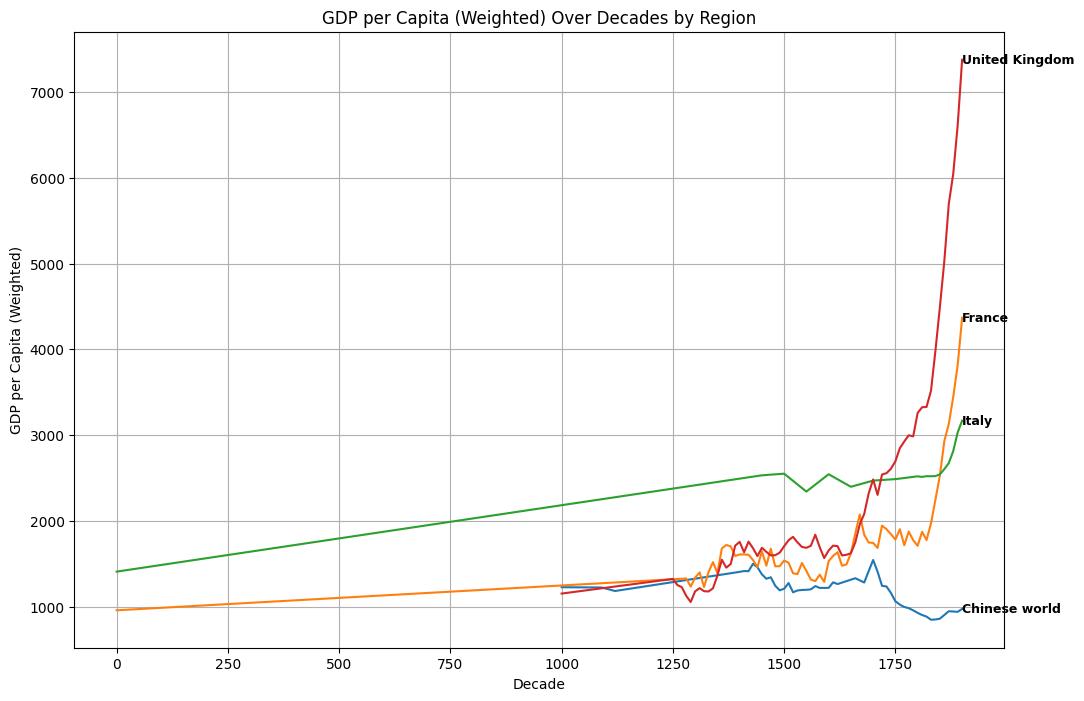

In [47]:
import matplotlib.pyplot as plt

import numpy as np

# Re-plotting with country labels near each line
plt.figure(figsize=(12, 8))

for region in df_fig['region'].unique():
    subset = df_fig[df_fig['region'] == region]
    plt.plot(subset['decade'], subset['gdp_pc_weighted'], label=region)
    
    # Adding text label near the end of each line
    plt.text(subset['decade'].values[-1], subset['gdp_pc_weighted'].values[-1], region, 
             verticalalignment='center', fontsize=9, weight='bold')

# Adding plot details
plt.title("GDP per Capita (Weighted) Over Decades by Region")
plt.xlabel("Decade")
plt.ylabel("GDP per Capita (Weighted)")
plt.grid(visible=True)

plt.show()


### Reading

In [49]:
import pandas as pd
df = pd.read_csv('data/gdp_weighted_pop_decade.csv')
df = df[df['decade']>=1800]
df

,region,decade,gdp_pc_weighted,pop
8,Arabic world,1820,832.465167,1724.111111
9,Arabic world,1870,1091.754910,2245.300000
11,Balkans,1830,1586.000000,2617.000000
12,Balkans,1840,1925.636364,2778.545455
13,Balkans,1850,1694.000000,3044.777778
...,...,...,...,...
698,United Kingdom,1860,5028.818182,28901.909091
699,United Kingdom,1870,5695.222222,31388.444444
700,United Kingdom,1880,6045.818182,34527.636364
701,United Kingdom,1890,6611.666667,37526.666667
